In [1]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [22]:
def stat_summary(X, iqrl=0.25, iqrr=0.75):
    '''
    Return for each timestamp (hr) return min, max, 0.25 quantile, 0.75 quantile, mean, var
    '''
    return pd.DataFrame(np.array([np.min(X, axis=0), np.quantile(X, axis=0, q=iqrl), np.median(X, axis=0), 
          np.quantile(X, axis=0, q=iqrr), np.max(X, axis=0), np.mean(X, axis=0), np.var(X, axis=0), np.std(X, axis=0)]).transpose(),
                        columns=["Min", "0.25Q", "Med", "0.75Q", "Max", "Mean", "Var", "StD"])

def trend(X, span = None):
    '''
    Return EWMA trend for signal samples
    '''
    if not span:
        span = X.shape[1]
    return pd.DataFrame(X).apply(lambda x: x.ewm(span=span).mean(), axis=1)

def train_test_val_split(X, y=None, test_size=0.2,  val_size=0.4):
    from sklearn.model_selection import train_test_split
    if y and y.__len__() > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size)
        return X_train, X_test, X_val, y_train, y_test, y_val
    else:
        X_train, X_test = train_test_split(X, test_size=test_size)
        X_test, X_val = train_test_split(X_test, test_size=val_size)
        return X_train, X_test, X_val

def reshapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(-1,1))
    return np.array(X_)

def shapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(1,-1)[0])
    return np.array(X_)


def meanShift(X, window=None):
    '''
    Apply MA on convolved signal and compute rs means
    '''
    # At this point X must be EWMA convolved already
    if not window:
        window = X.shape[1] // 2
    return pd.DataFrame(X).apply(lambda x: x.rolling(window=window).mean(), axis=1).iloc[:,window-1:]

def gradient(X, shift=1, threshold=0):
    '''
    First order gradient of signal. Eq to diff for discrete signal
    '''
    return pd.DataFrame(X).apply(lambda x: x.diff(periods=shift), axis=1).iloc[:,threshold:]

def bucketPeaks(peakIndex):
    '''
    Bucket into first half and second half
    '''
    return(sum(peakIndex <= 12), sum(peakIndex > 12)) 

def clean(X, autoencoder_C, threshold_mae = 0.2, applyTrend = False):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    if applyTrend:
        results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
        errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    else:
        results = autoencoder_C.predict(reshapeInput(X.values))
        errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors > threshold_mae)]

def clean_self(X, autoencoder_C, threshold_mae = 0.2):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    results = autoencoder_C.predict(reshapeInput(X.values))
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors < threshold_mae)]

In [3]:
A = pd.read_csv("../assets/data/cleaned/A.csv", index_col=0)
B = pd.read_csv("../assets/data/cleaned/B.csv", index_col=0)

In [4]:
A.shape, B.shape

((2679, 24), (1111, 24))

Cleaning B effects from A will prove to be more difficult

In [5]:
rand_idx = np.random.randint(0, min(A.__len__(), B.__len__()), 1)[0]

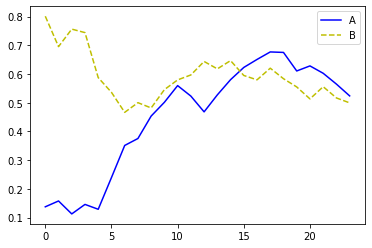

In [6]:
plt.plot(trend(A.values[rand_idx].reshape(1,-1)).values[0], 'b-',label="A")
plt.plot(trend(B.values[rand_idx].reshape(1,-1)).values[0], 'y--',label="B")
plt.legend()
plt.show()

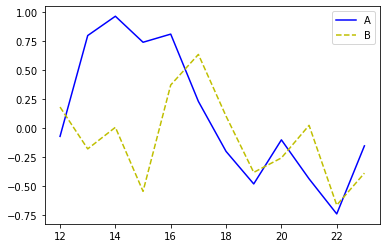

In [7]:
plt.plot(gradient(A.values[rand_idx].reshape(1,-1), 12).values[0], 'b-',label="A")
plt.plot(gradient(B.values[rand_idx].reshape(1,-1), 12).values[0], 'y--',label="B")
plt.legend()
plt.show()

In [8]:
sig.find_peaks(gradient(A.values[rand_idx].reshape(1,-1), 12).values[0]),sig.find_peaks(gradient(B.values[rand_idx].reshape(1,-1), 12).values[0]) 

((array([14, 16, 20], dtype=int64), {}),
 (array([14, 17, 21], dtype=int64), {}))

In [9]:
rand_idx

124

787, 360

Also check gradient peaks ( shifts in gradient ) at 12

<b><u>1. Lets first try learning the B pattern using trended data</u></b>

In [10]:
X_train, X_test, X_val = train_test_val_split(trend(B.values).values, test_size=0.1)

In [11]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

timesteps = 24
input_dim = 1 
latent_dim = 1

inputs = tf.keras.Input(shape=(timesteps, input_dim))
encoded = tf.keras.layers.LSTM(latent_dim)(inputs)

decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder_Bt = tf.keras.Model(inputs, decoded)

In [12]:
sequence_autoencoder_Bt.compile(loss="mae", metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
sequence_autoencoder_Bt.fit(reshapeInput(X_train), reshapeInput(X_train), batch_size=50, epochs=500, 
                         validation_data=(reshapeInput(X_val), reshapeInput(X_val)), 
                         callbacks=tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True))

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/20 [==========================>...] - ETA: 0s - loss: 0.3916 - mse: 0.1685WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000021E63C1B0D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

20/20 [==============================] - 0s 14ms/step - loss: 0.0739 - mse: 0.0140 - val_loss: 0.0734 - val_mse: 0.0143
Epoch 49/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0736 - mse: 0.0140 - val_loss: 0.0734 - val_mse: 0.0143
Epoch 50/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0741 - mse: 0.0140 - val_loss: 0.0732 - val_mse: 0.0141
Epoch 51/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0742 - mse: 0.0143 - val_loss: 0.0731 - val_mse: 0.0140
Epoch 52/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0728 - mse: 0.0136 - val_loss: 0.0729 - val_mse: 0.0139
Epoch 53/500
20/20 [==============================] - 0s 13ms/step - loss: 0.0738 - mse: 0.0139 - val_loss: 0.0729 - val_mse: 0.0138
Epoch 54/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0728 - mse: 0.0134 - val_loss: 0.0728 - val_mse: 0.0137
Epoch 55/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0748 

20/20 [==============================] - 0s 15ms/step - loss: 0.0710 - mse: 0.0116 - val_loss: 0.0709 - val_mse: 0.0118
Epoch 110/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0714 - mse: 0.0116 - val_loss: 0.0708 - val_mse: 0.0118
Epoch 111/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0712 - mse: 0.0115 - val_loss: 0.0708 - val_mse: 0.0118
Epoch 112/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0716 - mse: 0.0116 - val_loss: 0.0708 - val_mse: 0.0118
Epoch 113/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0702 - mse: 0.0112 - val_loss: 0.0708 - val_mse: 0.0118
Epoch 114/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0708 - mse: 0.0116 - val_loss: 0.0708 - val_mse: 0.0117
Epoch 115/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0708 - mse: 0.0114 - val_loss: 0.0709 - val_mse: 0.0117
Epoch 116/500
20/20 [==============================] - 0s 12ms/step - loss: 

20/20 [==============================] - 0s 12ms/step - loss: 0.0703 - mse: 0.0109 - val_loss: 0.0703 - val_mse: 0.0114
Epoch 171/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0710 - mse: 0.0112 - val_loss: 0.0703 - val_mse: 0.0114
Epoch 172/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0708 - mse: 0.0109 - val_loss: 0.0703 - val_mse: 0.0114
Epoch 173/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0701 - mse: 0.0108 - val_loss: 0.0703 - val_mse: 0.0114
Epoch 174/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0697 - mse: 0.0106 - val_loss: 0.0703 - val_mse: 0.0114
Epoch 175/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0694 - mse: 0.0107 - val_loss: 0.0704 - val_mse: 0.0114
Epoch 176/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0693 - mse: 0.0106 - val_loss: 0.0703 - val_mse: 0.0113
Epoch 177/500
20/20 [==============================] - 0s 12ms/step - loss: 

20/20 [==============================] - 0s 12ms/step - loss: 0.0704 - mse: 0.0108 - val_loss: 0.0702 - val_mse: 0.0112
Epoch 232/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0701 - mse: 0.0108 - val_loss: 0.0702 - val_mse: 0.0112
Epoch 233/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0704 - mse: 0.0107 - val_loss: 0.0702 - val_mse: 0.0112
Epoch 234/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0702 - mse: 0.0108 - val_loss: 0.0701 - val_mse: 0.0112
Epoch 235/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0700 - mse: 0.0107 - val_loss: 0.0702 - val_mse: 0.0112
Epoch 236/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0699 - mse: 0.0107 - val_loss: 0.0702 - val_mse: 0.0112
Epoch 237/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0693 - mse: 0.0105 - val_loss: 0.0701 - val_mse: 0.0112
Epoch 238/500
20/20 [==============================] - 0s 12ms/step - loss: 

20/20 [==============================] - 0s 13ms/step - loss: 0.0693 - mse: 0.0106 - val_loss: 0.0701 - val_mse: 0.0112
Epoch 293/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0699 - mse: 0.0109 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 294/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0697 - mse: 0.0105 - val_loss: 0.0701 - val_mse: 0.0112
Epoch 295/500
20/20 [==============================] - 0s 13ms/step - loss: 0.0698 - mse: 0.0107 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 296/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0694 - mse: 0.0105 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 297/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0697 - mse: 0.0106 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 298/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0700 - mse: 0.0107 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 299/500
20/20 [==============================] - 0s 11ms/step - loss: 

20/20 [==============================] - 0s 12ms/step - loss: 0.0695 - mse: 0.0106 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 354/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0698 - mse: 0.0105 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 355/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0698 - mse: 0.0105 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 356/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0692 - mse: 0.0104 - val_loss: 0.0702 - val_mse: 0.0111
Epoch 357/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0699 - mse: 0.0106 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 358/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0691 - mse: 0.0104 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 359/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0697 - mse: 0.0106 - val_loss: 0.0701 - val_mse: 0.0111
Epoch 360/500
20/20 [==============================] - 0s 12ms/step - loss: 

20/20 [==============================] - 0s 12ms/step - loss: 0.0689 - mse: 0.0103 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 415/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0695 - mse: 0.0105 - val_loss: 0.0699 - val_mse: 0.0110
Epoch 416/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0700 - mse: 0.0106 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 417/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0707 - mse: 0.0108 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 418/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0699 - mse: 0.0106 - val_loss: 0.0700 - val_mse: 0.0111
Epoch 419/500
20/20 [==============================] - 0s 11ms/step - loss: 0.0684 - mse: 0.0102 - val_loss: 0.0699 - val_mse: 0.0111
Epoch 420/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0693 - mse: 0.0104 - val_loss: 0.0699 - val_mse: 0.0111
Epoch 421/500
20/20 [==============================] - 0s 12ms/step - loss: 

20/20 [==============================] - 0s 14ms/step - loss: 0.0690 - mse: 0.0103 - val_loss: 0.0698 - val_mse: 0.0110
Epoch 476/500
20/20 [==============================] - 0s 13ms/step - loss: 0.0694 - mse: 0.0105 - val_loss: 0.0698 - val_mse: 0.0110
Epoch 477/500
20/20 [==============================] - 0s 13ms/step - loss: 0.0696 - mse: 0.0104 - val_loss: 0.0699 - val_mse: 0.0110
Epoch 478/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0687 - mse: 0.0102 - val_loss: 0.0699 - val_mse: 0.0110
Epoch 479/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0697 - mse: 0.0107 - val_loss: 0.0699 - val_mse: 0.0110
Epoch 480/500
20/20 [==============================] - 0s 13ms/step - loss: 0.0695 - mse: 0.0104 - val_loss: 0.0699 - val_mse: 0.0110
Epoch 481/500
20/20 [==============================] - 0s 12ms/step - loss: 0.0692 - mse: 0.0104 - val_loss: 0.0698 - val_mse: 0.0110
Epoch 482/500
20/20 [==============================] - 0s 12ms/step - loss: 

In [15]:
mean_absolute_error(X_test, shapeInput(sequence_autoencoder_Bt.predict(X_test)))

0.06426964216406723

In [16]:
mean_absolute_error(trend(A.values).values, shapeInput(sequence_autoencoder_Bt.predict(reshapeInput(trend(A.values).values))))

0.06898577404011555

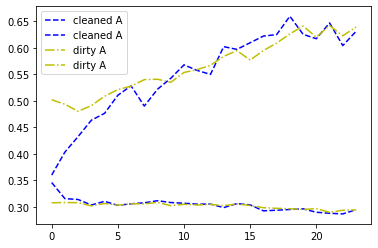

In [25]:
A_ = clean(A, sequence_autoencoder_Bt, 0.068, applyTrend=True)
plt.plot(stat_summary(A_).iloc[:,[2,7]], 'b--',label='cleaned A')
plt.plot(stat_summary(A).iloc[:,[2,7]], 'y-.',label='dirty A')
plt.legend()
plt.show()

pd.DataFrame(A_).to_csv("../assets/data/cleaned/A_.csv")

sequence_autoencoder_Bt.save("../assets/models/B_autoencoder_final_trend/")

## Restart kernel due to memory issues

In [25]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

In [31]:
def stat_summary(X, iqrl=0.25, iqrr=0.75):
    '''
    Return for each timestamp (hr) return min, max, 0.25 quantile, 0.75 quantile, mean, var
    '''
    return pd.DataFrame(np.array([np.min(X, axis=0), np.quantile(X, axis=0, q=iqrl), np.median(X, axis=0), 
          np.quantile(X, axis=0, q=iqrr), np.max(X, axis=0), np.mean(X, axis=0), np.var(X, axis=0), np.std(X, axis=0)]).transpose(),
                        columns=["Min", "0.25Q", "Med", "0.75Q", "Max", "Mean", "Var", "StD"])

def trend(X, span = None):
    '''
    Return EWMA trend for signal samples
    '''
    if not span:
        span = X.shape[1]
    return pd.DataFrame(X).apply(lambda x: x.ewm(span=span).mean(), axis=1)

def train_test_val_split(X, y=None, test_size=0.2,  val_size=0.4):
    from sklearn.model_selection import train_test_split
    if y and y.__len__() > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size)
        return X_train, X_test, X_val, y_train, y_test, y_val
    else:
        X_train, X_test = train_test_split(X, test_size=test_size)
        X_test, X_val = train_test_split(X_test, test_size=val_size)
        return X_train, X_test, X_val

def reshapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(-1,1))
    return np.array(X_)

def shapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(1,-1)[0])
    return np.array(X_)


def meanShift(X, window=None):
    '''
    Apply MA on convolved signal and compute rs means
    '''
    # At this point X must be EWMA convolved already
    if not window:
        window = X.shape[1] // 2
    return pd.DataFrame(X).apply(lambda x: x.rolling(window=window).mean(), axis=1).iloc[:,window-1:]

def gradient(X, shift=1, threshold=0):
    '''
    First order gradient of signal. Eq to diff for discrete signal
    '''
    return pd.DataFrame(X).apply(lambda x: x.diff(periods=shift), axis=1).iloc[:,threshold:]

def bucketPeaks(peakIndex):
    '''
    Bucket into first half and second half
    '''
    return(sum(peakIndex <= 12), sum(peakIndex > 12)) 

def clean(X, autoencoder_C, threshold_mae = 0.2, applyTrend = False):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    if applyTrend:
        results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
        errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    else:
        results = autoencoder_C.predict(reshapeInput(X.values))
        errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors > threshold_mae)]

def clean_self(X, autoencoder_C, threshold_mae = 0.2, applyTrend = False):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    if applyTrend:
        results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
        errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    else:
        results = autoencoder_C.predict(reshapeInput(X.values))
        errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    #results = autoencoder_C.predict(reshapeInput(X.values))
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    #errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors < threshold_mae)]

In [3]:
A = pd.read_csv("../assets/data/cleaned/A_.csv", index_col=0)
B = pd.read_csv("../assets/data/cleaned/B.csv", index_col=0)
C = pd.read_csv("../assets/data/cleaned/C.csv", index_col=0)

In [4]:
X = np.row_stack((A,B,C))
Y = [0]*(A.__len__()) + [1]*(B.__len__()) + [2]*C.__len__()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(Y), test_size=0.1)

In [17]:
np.sum(y_train, axis=0)

array([1086., 1010., 1202.], dtype=float32)

In [18]:
from imblearn.under_sampling import RandomUnderSampler
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)

C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [19]:
np.sum(y_train, axis=0)

array([1010, 1010, 1010])

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100).fit(X_train, np.argmax(y_train, axis=1))

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error

In [22]:
confusion_matrix(np.argmax(y_test, axis=1), rf.predict(X_test))

array([[82, 41, 11],
       [37, 41, 23],
       [16, 21, 95]], dtype=int64)

In [24]:
print(classification_report(np.argmax(y_test, axis=1), rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       134
           1       0.40      0.41      0.40       101
           2       0.74      0.72      0.73       132

    accuracy                           0.59       367
   macro avg       0.58      0.58      0.58       367
weighted avg       0.60      0.59      0.60       367



Lets check the recon error on C

In [26]:
sequence_autoencoder_Bt = load_model("../assets/models/B_autoencoder_final_trend")

In [30]:
mean_absolute_error(trend(C.values).values, shapeInput(sequence_autoencoder_Bt.predict(reshapeInput(trend(C.values).values))))

0.05945399884402288

1. These show that B is still somewhat noisy but with a deeper model, we can diff bw B and C
2. We can now use these cleaned datasets for our prediction model
3. A non-temporal model (RF) can now better segregate between A and B and C